In [79]:

# Imports
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
# Load dataset
pd.set_option('display.max_columns', None)
try:
    df_full = pd.read_csv("./Dementia Prediction Dataset(1).csv", on_bad_lines='skip' )
except FileNotFoundError:
    raise FileNotFoundError("Dataset file not found. Please check the filename and path.")

/tmp/ipython-input-2601407702.py:4: DtypeWarning: Columns (20,24,26,28,41,46,48,51,61,63,65,67,69,71,92,93,94,95,96,97,98,99,100,101,102,103,156,165,176,179,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,397,399,401,423,432,445,454,494,574,605,613,638,674,690,707,710,727,738,744,812,843,904,959,960,961,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df_full = pd.read_csv("./Dementia Prediction Dataset(1).csv", on_bad_lines='skip' )


In [81]:
# Keep only non-medical columns
columns_to_keep = [
    # Diagnosis
    'DEMENTED',
    # Form Header
    'NACCID','NACCADC','PACKET','FORMVER','VISITMO','VISITDAY','VISITYR','NACCVNUM','NACCAVST','NACCNVST','NACCDAYS','NACCFDYS',
    # Milestones
    'NACCDIED','NACCMOD','NACCYOD','NACCACTV','NACCNOVS','NACCDSMO','NACCDSDY','NACCDSYR','NACCNURP','NACCNRMO','NACCNRDY','NACCNRYR','NACCMDSS','NACCPAFF',
    # Form T1: Inclusion Form
    'TELCOV','TELMOD','HEIGHT','WEIGHT',
    # Form A1: Subject Demographics
    'NACCREAS','NACCREFR','BIRTHMO','BIRTHYR','SEX','HISPANIC','HISPOR','HISPORX','RACE','RACEX','RACESEC','RACESECX','RACETER','RACETERX','PRIMLANG','PRIMLANX','EDUC','MARISTAT','NACCLIVS','INDEPEND','RESIDENC','HANDED','NACCAGE','NACCAGEB','NACCNIHR',
    # Form A2: Co-participant Demographics
    'INBIRMO','INBIRYR','INSEX','NEWINF','INHISP','INHISPOR','INHISPOX','INRACE','INRACEX','INRASEC','INRASECX','INRATER','INRATERX','INEDUC','INRELTO','INRELTOX','INKNOWN','INLIVWTH','INVISITS','INCALLS','INRELY','NACCNIN',
    # Forms C1, C2, C2T: Neuropsych Battery (Administrative Vars)
    'MMSECOMP','MMSELOC','MMSELAN','MMSELANX','NPSYCLOC','NPSYLAN','NPSYLANX','LOGIMO','LOGIDAY','LOGIYR','LOGIPREV','NACCC1','MOCACOMP','MOCALOC','MOCALAN','MOCALANX','NACCC2','MODCOMM','RESPVAL','RESPDIST','RESPINTR','RESPDISN','RESPASST','RESPOTH','RESPOTHX',
    # Form Z1X: Form Checklist
    'LANGA1','LANGA2','LANGA3','LANGA4','LANGA5','LANGB1','LANGB4','LANGB5','LANGB6','LANGB7','LANGB8','LANGB9','LANGC2','LANGD1','LANGD2','LANGB3F','LANGB9F','LANGC1F','LANGC2F','LANGC3F','LANGC4F','LANGC5F','LANGC6F','LANGE2F','LANGE3F','LANGCLS','CLSSUB',
    # Form CLS: Linguistic History Form
    'NACCSPNL','NACCENGL','APREFLAN','AYRSPAN','AYRENGL','APCSPAN','APCENGL','ASPKSPAN','AREASPAN','AWRISPAN','AUNDSPAN','ASPKENGL','AREAENGL','AWRIENGL','AUNDENGL',
    # Other data available at NACC
    'NACCFTD','NACCLBDM','NACCNMRI','NACCMRSA','NACCNAPA','NACCAPSA','NACCACSF','NACCPCSF','NACCTCSF','NACCAUTP'
]

df = df_full[df_full.columns.intersection(columns_to_keep)]


In [82]:
# Replace special codes with NaN
special_codes = [-4, -3, -2, -1, 88, 98, 99, 888, 8888, 999, 9999]
df.replace(special_codes, pd.NA, inplace=True)

/tmp/ipython-input-500366366.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(special_codes, pd.NA, inplace=True)


In [83]:
# Drop columns with >60% missing values
threshold = 0.6
df = df.loc[:, df.isnull().mean() < threshold]

In [84]:
# Fill remaining missing values
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col].fillna(df[col].mean(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-2621513022.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-2621513022.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [85]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [86]:
# Split features and target
X = df.drop("DEMENTED", axis=1)
Y = df["DEMENTED"]

In [87]:
# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

In [88]:
# Encode categorical variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [89]:
df['DEMENTED'] = df['DEMENTED'].astype(int)

In [90]:
  X = df.drop("DEMENTED", axis=1)
  Y = df["DEMENTED"]

In [91]:
id_columns = [
    'NACCID', 'NACCADC', 'PACKET', 'FORMVER',
    'VISITMO', 'VISITDAY', 'VISITYR', 'NACCVNUM', 'NACCAVST', 'NACCNVST',
    'NACCDAYS', 'NACCFDYS'
]
# Keep only columns that exist in your dataset
id_columns_in_df = [col for col in id_columns if col in X.columns]

# Drop them
X = X.drop(columns=id_columns_in_df)
cat_cols = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


In [92]:
# Train Random Forest
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', None]
}
rf = RandomForestClassifier(random_state=42)
clf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1',
    cv=3,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
24 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='f1')

In [93]:
# Predictions and evaluation
Y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))


Accuracy: 0.8962199312714777
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1859
           1       0.86      0.85      0.86      1051

    accuracy                           0.90      2910
   macro avg       0.89      0.89      0.89      2910
weighted avg       0.90      0.90      0.90      2910



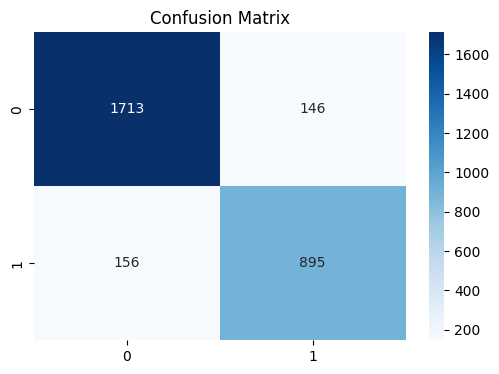

In [94]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

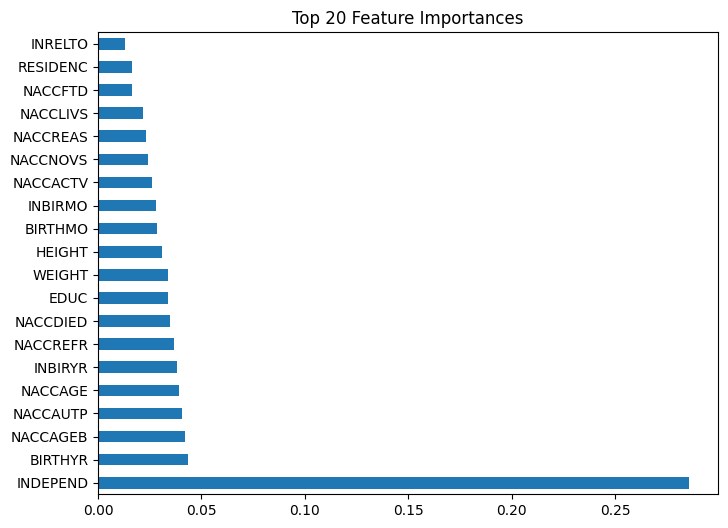

In [95]:
# Feature Importance
best_model = clf.best_estimator_
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importances.nlargest(20).plot(kind='barh', figsize=(8,6))
plt.title("Top 20 Feature Importances")
plt.show()